# Joint embedding of fragmentation spectra and chemical compounds

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import keras
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

from rdkit.Chem import AllChem
from rdkit import Chem

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from functions import *

Using TensorFlow backend.


### Load GNPS data

Data contains SMILES of known molecules and also their fragmentation spectra

In [3]:
import pickle
with open('../data/gnps_massbank_data.p', 'rb') as f:
    data = pickle.load(f)

### Create spectra embedding

Load a simple dense model. This was trained on the training data and is used to map

- From: fragmentation spectra 
- To: 100-dimensional vector representation.

TODO: try better representation: vae, LDA topic decomposition?

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 881)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               88200     
_________________________________________________________________
dense_2 (Dense)              (None, 881)               88981     
Total params: 177,181
Trainable params: 177,181
Non-trainable params: 0
_________________________________________________________________


/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


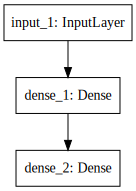

In [4]:
spectra_autoencoder = keras.models.load_model('../models/spectra_autoencoder_gnps_massbank.h5')
spectra_encoder = keras.models.load_model('../models/spectra_encoder_gnps_massbank.h5')
spectra_decoder = keras.models.load_model('../models/spectra_decoder_gnps_massbank.h5')
spectra_autoencoder.summary()
svg = plot_model_in_notebook(spectra_autoencoder)
svg

In [5]:
spectra_latent = spectra_encoder.predict(data['spectra'])
print(spectra_latent.shape)

(7901, 100)


[ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 213 214 215 216 217 218 219 220 222 223 225
 226 227 228 229 230 231 232 233 234 236 237 239 240 241 242 243 244 245
 246 248 250 252 253 254 255 257 259 260 261 262 263 264 266 269 270 272
 273 274 275 286 288 290 297 298 300 302 304 305 308 312 313 315 316 318
 319 320 321 322 326 327 328 329 330 331 332 333 335 336 338 339 340 341
 343 344 346 347 348 352 355 356 357 358 359 360 361 362 368 369 370 371
 372 373 374 375 381 384 385 387 390 393 398 401 402 404 417 419 420 421
 422 423 425 428 429 430 431 435 438 440 441 442 44

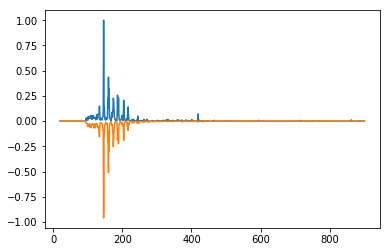

[ 45  46  48  49  51  53  54  55  56  57  58  59  61  62  63  64  65  66
  67  68  69  71  72  73  75  76  79  81  82  83  85  86  87  88  90  91
  92  93  95  96  97  98 100 101 102 103 105 106 107 108 109 110 112 113
 114 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 142 143 144 145 146 147 148 149 150 151 152 155
 156 157 158 159 160 161 162 163 164 165 167 169 170 171 172 173 174 175
 178 179 184 185 186 187 188 192 193 194 198 199 200 201 203 205 206 207
 210 211 212 213 215 216 217 224 225 226 227 228 229 231 240 243 249 253
 255 256 257 267 279 329 446 470 527 679 784 804 856 865 878]


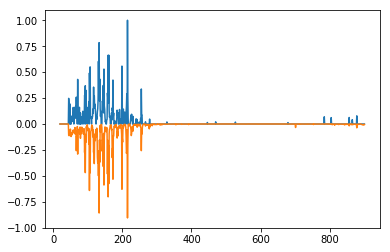

[ 47  48  51  53  56  57  63  64  65  67  69  70  71  72  74  76  78  79
  80  81  82  83  85  86  88  89  90  92  93  94  96  97  99 100 101 102
 104 105 106 109 110 111 114 117 118 119 120 121 122 123 126 127 128 129
 130 133 134 135 136 137 138 139 140 141 142 145 146 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 164 165 166 167 168 169 171 172 173
 174 175 176 177 179 181 182 183 185 186 187 188 189 190 191 192 194 195
 196 197 198 199 201 203 204 206 207 208 209 210 211 212 213 214 215 216
 220 221 223 224 225 226 228 229 230 231 232 233 234 235 240 242 243 244
 580]


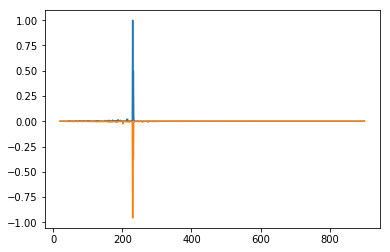

[ 39  41  42  43  50  51  52  53  54  55  56  57  60  62  63  64  65  66
  67  68  69  71  73  74  75  76  77  78  79  80  81  86  87  88  89  90
  91  92  93  94  95  96  97 101 102 103 104 105 106 107 113 114 115 116
 117 118 128 129 130 131 132 133 134 140 141 142 143 144 145 158 159 160]


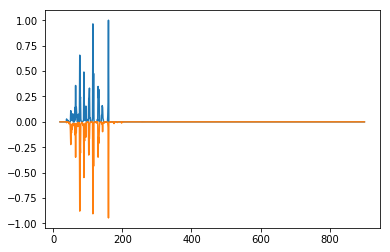

[ 44  59  70  72  86  87  88 100 110 112 115 136 244 245 255 269 272 329
 343 464 506 513 591 619 700 756 853]


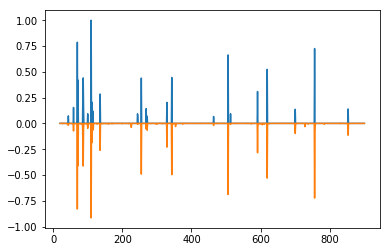

[102 113 114 115 116 117 118 119 120 122 123 124 125 126 127 128 130 131
 132 133 134 135 136 137 138 143 144 145 146 147 148 149 150 151 152 161
 162 163 164 165 180 181 182]


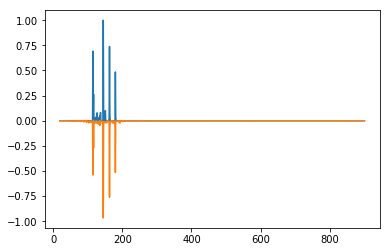

[ 52  54  55  60  66  67  81  91  97 101 107 109 121 133 135 137 141 147
 149 152 159 165 167 169 171 173 177 181 183 185 187 195 197 198 199 211
 213 215 219 223 225 226 227 239 241 247 251 253 257 269 271 325 389 407
 425 478 481]


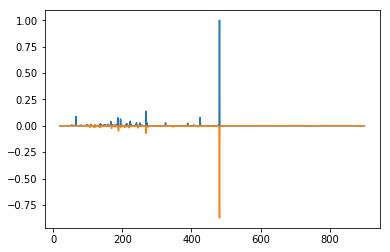

[ 47  48  50  52  53  54  55  56  57  60  63  65  67  68  69  70  71  72
  73  74  75  76  78  79  80  82  83  87  91  92  93  94  95  98  99 101
 102 104 105 107 108 109 111 112 113 115 116 117 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 271 272 273 274 275 276 277 278 279 280 281 282 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 304 306 307 308
 309 310 311 312 313 314 315 316 317 319 320 321 32

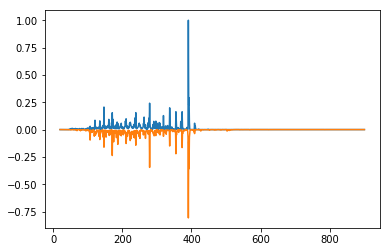

[ 89 106 117 118 121 134 136 145 146 147 149 150 177 178 179]


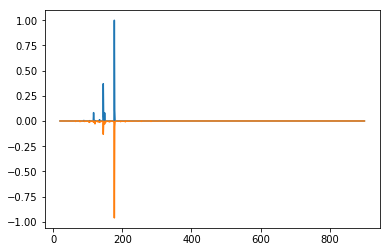

[ 72  74  86  98 100 116 129 132 141 145 155 157 165 183 218 242]


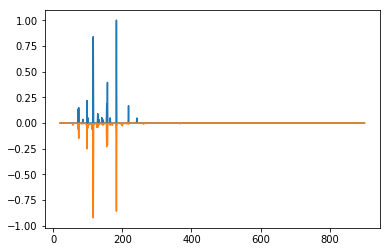

In [7]:
spectra_decoded = spectra_decoder.predict(spectra_latent)
for idx in range(10):
    pos = np.nonzero(data['spectra'][idx])
    print(data['vocab'][pos])
    plt.plot(data['vocab'], data['spectra'][idx])
    plt.plot(data['vocab'], -spectra_decoded[idx])
    plt.show()

In [8]:
spectra_latent = StandardScaler().fit_transform(spectra_latent)

### Create SMILES embedding

Load the molecular autoencoder model from https://github.com/maxhodak/keras-molecules, trained on 500k small compounds from Pubchem. This is used to map:

- From: SMILES string.
- To: 100-dimensional vector representation.

In [9]:
# model_file = '../models/pubchem_500k_val_loss_0.4368_val_acc_0.9654_MoleculeVAE.h5'
# charset_file = '../preprocessed/pubchem_500k_charset.p'
# LATENT_DIM = 100

# molecule_autoencoder, charset = load_molecule_vae(model_file, charset_file, LATENT_DIM)
# molecule_autoencoder.autoencoder.summary()
# plot_model_in_notebook(molecule_autoencoder.autoencoder)

In [10]:
# input_array = get_input_arr(data['smiles'], charset)
# mona_latent = encode(molecule_autoencoder, input_array)
# mona_latent = StandardScaler().fit_transform(mona_latent)
# print(mona_latent.shape)

Try using molecular fingerprint instead

In [11]:
from rdkit.Chem.Fingerprints import FingerprintMols

In [12]:
fingerprints = []
spectra = []
assert len(data['smiles']) == len(data['spectra'])

max_length = 0
for i in range(len(data['smiles'])):
    mol = Chem.MolFromSmiles(data['smiles'][i])
    spec = data['spectra'][i]
    try:
        fp = FingerprintMols.FingerprintMol(mol)
        bits = np.array(list(fp.GetOnBits()))
        if max(bits) > max_length:
            max_length = max(bits)
        fingerprints.append(bits)
        spectra.append(data['spectra'][i])
    except Exception:
        print('Invalid smile', data['smiles'][i])
        continue

In [13]:
len(fingerprints)

7901

In [14]:
fingerprints[0]

array([   0,    1,    5, ..., 2041, 2045, 2047])

In [15]:
max_length

2047

In [16]:
fingerprint_arr = np.zeros((len(fingerprints), max_length+1))
for i in range(len(fingerprints)):
    fingerprint = fingerprints[i]
    for bit in fingerprint:
        fingerprint_arr[i][bit] = 1

In [17]:
data['spectra']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00518876]])

In [18]:
spectra = np.array(spectra)

In [19]:
type(spectra)

numpy.ndarray

In [20]:
spectra_latent = spectra_encoder.predict(spectra)
print(spectra_latent.shape)

(7901, 100)


In [21]:
spectra_latent.shape

(7901, 100)

In [22]:
fingerprint_arr.shape

(7901, 2048)

In [23]:
fingerprint_arr = StandardScaler().fit_transform(fingerprint_arr)

In [24]:
fingerprint_arr[0]

array([ 0.74375719,  1.05746421, -1.31355341, ...,  1.43900471,
       -0.59367314,  0.93253239])

In [25]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

spectra_latent, fingerprint_arr = unison_shuffled_copies(spectra_latent, fingerprint_arr)

### Try joint embedding

Objective: build a model that projects spectra and molecules in the same representation space, so that a spectra is close to its molecule in that space, and far away from dissimilar spectra and dissimilar molecules.

We do this by minimising the margin loss of spectra to positive and negative training examples (molecules). 

See:

- https://pageperso.lis-lab.fr/benoit.favre/dl4nlp/tutorials/05-caption.pdf
- https://arxiv.org/abs/1511.06078

In [26]:
def get_embedding_model(input_dim_spectra, input_dim_molecule, embedding_dim):
    
    spectra_input = Input(shape=(input_dim_spectra,))
    smile_input = Input(shape=(input_dim_molecule,))
    noise_input = Input(shape=(input_dim_molecule,))
        
    spectra_pipeline = Dense(embedding_dim, use_bias=False)(spectra_input)
    spectra_pipeline = BatchNormalization()(spectra_pipeline)
    spectra_pipeline = Activation('relu')(spectra_pipeline)
    spectra_pipeline = Dense(embedding_dim, activation='relu')(spectra_pipeline)

    smile_dense1 = Dense(embedding_dim, use_bias=False) 
    bn = BatchNormalization()
    activation = Activation('relu')
    smile_dense2 = Dense(embedding_dim, activation='relu')
    smile_pipeline = smile_dense2(activation(bn(smile_dense1(smile_input))))
    noise_pipeline = smile_dense2(activation(bn(smile_dense1(noise_input))))        

    positive_pair = merge([spectra_pipeline, smile_pipeline], mode='dot')
    negative_pair = merge([spectra_pipeline, noise_pipeline], mode='dot')
    concat_output = merge([positive_pair, negative_pair], mode='concat')
    embedding_model = Model(input=[spectra_input, smile_input, noise_input], output=concat_output)

    l2_norm = Lambda(lambda  x: K.l2_normalize(x, axis=1))    
    spectra_encoder = Model(input=spectra_input, output=l2_norm(spectra_pipeline))
    smile_encoder = Model(input=smile_input, output=l2_norm(smile_pipeline))
    
    # also see https://github.com/keras-team/keras/issues/150
    def custom_loss(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.sum(K.maximum(0., 1. - positive + negative))
    
    def accuracy(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.mean(positive > negative)
    
    embedding_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])
    return embedding_model, spectra_encoder, smile_encoder

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          20000       input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `k

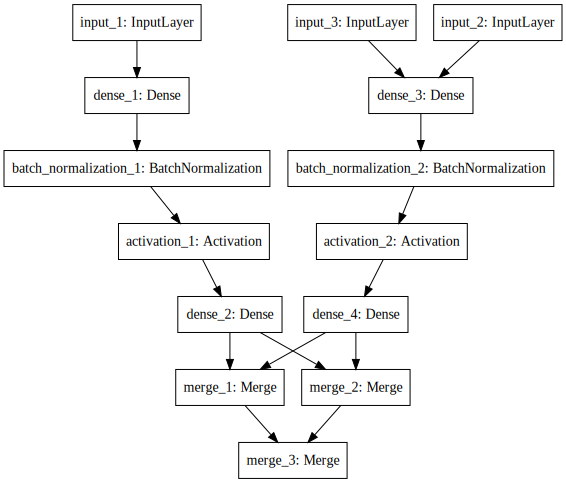

In [27]:
EMBEDDING_DIM = 200
input_dim_spectra = spectra_latent.shape[1]
input_dim_molecule = fingerprint_arr.shape[1]
joint_embedding_model, spectra_encoder, smile_encoder = get_embedding_model(input_dim_spectra, 
                                                                            input_dim_molecule, 
                                                                            EMBEDDING_DIM)
joint_embedding_model.summary()
plot_model_in_notebook(joint_embedding_model)

In [28]:
pos = int(len(spectra_latent) * 0.8)
remaining = len(spectra_latent) - pos
print(pos, remaining)

noise = np.copy(fingerprint_arr)
fake_labels = np.zeros((len(spectra_latent), 1))

X_train = [spectra_latent[:pos], fingerprint_arr[:pos], noise[:pos]]
Y_train = fake_labels[:pos]
X_test = [spectra_latent[-remaining:], fingerprint_arr[-remaining:], noise[-remaining:]]
Y_test = fake_labels[-remaining:]

# smiles_train = fingerprint_arr[:pos]
# smiles_test = fingerprint_arr[-remaining:]
# spectra_train = fingerprint_arr[:pos]
# spectra_test = fingerprint_arr[-remaining:]

6320 1581


In [29]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
print(X_test[0].shape, X_test[1].shape, X_test[2].shape)

(6320, 100) (6320, 2048) (6320, 2048)
(1581, 100) (1581, 2048) (1581, 2048)


In [30]:
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
#                         verbose=1, epsilon=1e-5)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
# callbacks = [rlr, early_stop]

# tensorboard = keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0,  
#           write_graph=True, write_images=True)
# callbacks = [rlr, early_stop, tensorboard]
# if is_notebook():
#     callbacks.append(PlotLossesKeras())

TODO: generate mini-batch properly https://stackoverflow.com/questions/48568062/keras-custom-infinite-data-generator-with-shuffle

In [31]:
# actual training
for epoch in range(1000):
    if epoch % 10 == 0:
        print('\nIteration %d' % epoch)
        verbose=1
    else:
        verbose=0
    np.random.shuffle(noise) # shuffle mismatched smiles
    joint_embedding_model.fit(X_train, Y_train,
        validation_data=[X_test, Y_test], epochs=1,
        batch_size=32, verbose=verbose)


Iteration 0
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 3s 461us/step - loss: 26.7858 - accuracy: 0.6867 - val_loss: 18.4940 - val_accuracy: 0.7577

Iteration 10
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 316us/step - loss: 5.4671 - accuracy: 0.9348 - val_loss: 11.5533 - val_accuracy: 0.8590

Iteration 20
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 329us/step - loss: 3.5711 - accuracy: 0.9587 - val_loss: 11.4721 - val_accuracy: 0.8817

Iteration 30
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 352us/step - loss: 2.7129 - accuracy: 0.9695 - val_loss: 10.7776 - val_accuracy: 0.8880

Iteration 40
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 370us/step - loss: 2.6505 - accuracy: 0.9710 - v

6320/6320 [==============================] - 2s 275us/step - loss: 0.5354 - accuracy: 0.9943 - val_loss: 10.2696 - val_accuracy: 0.9108

Iteration 400
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 273us/step - loss: 0.3722 - accuracy: 0.9959 - val_loss: 8.9208 - val_accuracy: 0.9184

Iteration 410
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 277us/step - loss: 0.5174 - accuracy: 0.9948 - val_loss: 9.1703 - val_accuracy: 0.9102

Iteration 420
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 281us/step - loss: 0.4963 - accuracy: 0.9937 - val_loss: 9.0493 - val_accuracy: 0.9178

Iteration 430
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 283us/step - loss: 0.4879 - accuracy: 0.9945 - val_loss: 10.6647 - val_accuracy: 0.9026

Iteration 440
Train on 6320 sa

6320/6320 [==============================] - 2s 294us/step - loss: 0.2713 - accuracy: 0.9972 - val_loss: 9.1887 - val_accuracy: 0.9254

Iteration 790
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 270us/step - loss: 0.2541 - accuracy: 0.9983 - val_loss: 11.0055 - val_accuracy: 0.9077

Iteration 800
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 281us/step - loss: 0.2860 - accuracy: 0.9970 - val_loss: 10.1122 - val_accuracy: 0.9152

Iteration 810
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 278us/step - loss: 0.3423 - accuracy: 0.9959 - val_loss: 10.8529 - val_accuracy: 0.9064

Iteration 820
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 275us/step - loss: 0.2037 - accuracy: 0.9972 - val_loss: 10.5903 - val_accuracy: 0.9203

Iteration 830
Train on 6320 

In [32]:
# joint_embedding_model.save('../models/joint_embedding_small.h5')
# spectra_encoder.save('../models/joint_spectra_encoder_small.h5')
# smile_encoder.save('../models/joint_smile_encoder_small.h5')

### Visualise the joint embedding results

In [34]:
def visualise_embedding(spectra_data, molecule_data, spectra_encoder, smile_encoder):
    
    embedded_spectra = spectra_encoder.predict(spectra_data)
    embedded_molecules = smile_encoder.predict(molecule_data)
    embedded_combined = np.concatenate([embedded_spectra, embedded_molecules], axis=0)
    
    PCA_COMPONENTS = 20
    pca = PCA(n_components = PCA_COMPONENTS)
    latent_proj = pca.fit_transform(embedded_combined)
    covariance = pca.get_covariance()
    evr = pca.explained_variance_ratio_
    print('Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1]))
    print('Explained variations -- all components: %.2f' % np.sum(evr))
    print(evr)
        
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_proj[0:len(embedded_spectra), 0], latent_proj[0:len(embedded_spectra), 1], marker='x', c='red', s=1)
    plt.scatter(latent_proj[len(embedded_spectra)+1:, 0], latent_proj[len(embedded_spectra)+1:, 1], marker='.', c='blue', s=1)
    plt.title('Joint embedding of fragmentation spectra (red) and molecules (blue)')

Visualise embedding on training data

Explained variations -- first two PCs: 0.17
Explained variations -- all components: 0.47
[0.11085971 0.05900832 0.03067718 0.02657444 0.02259102 0.02077987
 0.0197447  0.01815901 0.01682015 0.0160575  0.01549557 0.01474176
 0.01416292 0.01367668 0.01335838 0.01303997 0.01284013 0.01199755
 0.0117547  0.01112182]


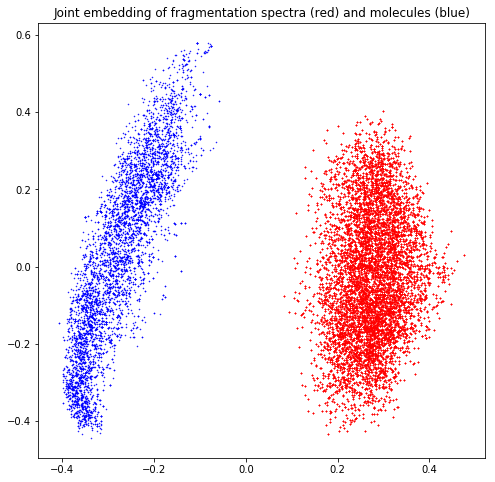

In [36]:
visualise_embedding(X_train[0], X_train[1], spectra_encoder, smile_encoder)

Visualise embedding on testing data

Explained variations -- first two PCs: 0.18
Explained variations -- all components: 0.48
[0.11417208 0.06296582 0.03150218 0.02692419 0.02297679 0.02099221
 0.0188917  0.01826756 0.01710845 0.01639542 0.01557861 0.01495795
 0.01453954 0.0141834  0.0133093  0.01268239 0.01245673 0.01187416
 0.01158813 0.01142973]


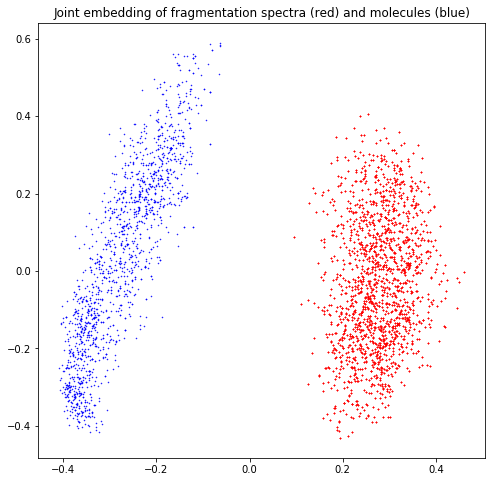

In [35]:
visualise_embedding(X_test[0], X_test[1], spectra_encoder, smile_encoder)

### Evaluation

In [37]:
embedded_spectra = spectra_encoder.predict(X_test[0])
embedded_molecules = smile_encoder.predict(X_test[1])

In [38]:
x = embedded_spectra[0]
print(x)
print(np.dot(x, x))

[0.         0.         0.         0.         0.         0.
 0.         0.05062676 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.21961719 0.         0.         0.
 0.37286913 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.6005933  0.         0.         0.2510979  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.05255866 0.12048506
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00854897
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.0872

In [39]:
plt.rcParams['figure.figsize'] = (8,8)

(1581, 1581)


Text(0.5,1.05,'Dot product')

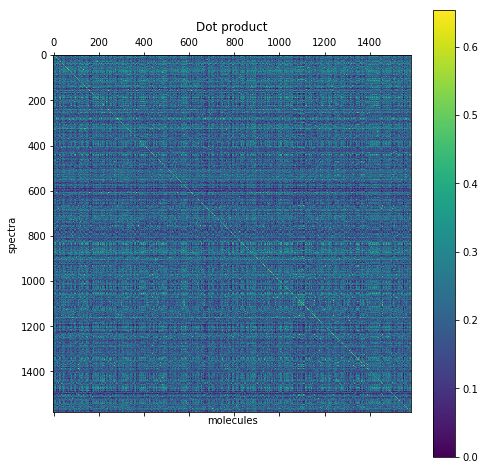

In [40]:
scores = np.dot(embedded_spectra, embedded_molecules.T)
print(scores.shape)
plt.matshow(scores)
plt.colorbar()
plt.xlabel('molecules')
plt.ylabel('spectra')
plt.title('Dot product')

In [41]:
def precision_at(n, scores):
    found = 0
    for i in range(len(scores)):
        row = scores[i]
        max_idx = row.argsort()[-n:][::-1]
        if i in max_idx:
            found += 1
            print(i, list(zip(max_idx, row[max_idx])))
            print()
    print('found=%d/%d %.2f' % (found, len(scores), float(found)/len(scores)))

In [42]:
precision_at(10, scores)

0 [(1424, 0.4535513), (610, 0.4535513), (500, 0.39293206), (246, 0.3810026), (1105, 0.37850127), (985, 0.3771677), (1407, 0.37578487), (881, 0.36903253), (0, 0.3686329), (1415, 0.3678749)]

1 [(1455, 0.48805624), (1154, 0.47731122), (1, 0.47731122), (1238, 0.47731122), (674, 0.47731122), (574, 0.47560585), (1088, 0.4661056), (1003, 0.46552348), (1103, 0.46409312), (901, 0.46250278)]

4 [(595, 0.61775315), (368, 0.6063137), (4, 0.60273665), (213, 0.6025609), (815, 0.60054487), (1231, 0.58727705), (1122, 0.56422985), (15, 0.5319519), (1572, 0.5281989), (717, 0.47375435)]

5 [(434, 0.46538264), (341, 0.46109158), (1324, 0.45482174), (563, 0.4541806), (78, 0.4541806), (1140, 0.45337003), (5, 0.452538), (40, 0.4494565), (111, 0.4494565), (1214, 0.44814116)]

7 [(641, 0.49601912), (1028, 0.49368852), (501, 0.4858733), (690, 0.48294106), (7, 0.48192143), (888, 0.48036867), (1481, 0.47668982), (1037, 0.469194), (703, 0.46902817), (1426, 0.4673106)]

8 [(1086, 0.44219947), (8, 0.44219947), (679

869 [(869, 0.45159584), (1123, 0.45159584), (588, 0.44396678), (716, 0.4302378), (143, 0.35751843), (334, 0.3420043), (1344, 0.3393221), (714, 0.33764216), (792, 0.3285064), (609, 0.32702854)]

871 [(1542, 0.4484144), (871, 0.44310352), (1563, 0.44310352), (462, 0.44310352), (893, 0.44128913), (570, 0.4403165), (1564, 0.43490654), (257, 0.42976946), (273, 0.4296556), (434, 0.4294747)]

872 [(177, 0.46947262), (872, 0.4691132), (1004, 0.45026973), (895, 0.44751427), (155, 0.4465555), (504, 0.44565964), (1054, 0.43925187), (135, 0.43574408), (741, 0.434585), (53, 0.4320792)]

873 [(363, 0.4476987), (873, 0.44571388), (676, 0.441815), (1479, 0.441815), (634, 0.4389721), (1079, 0.43460318), (535, 0.43460318), (600, 0.43460318), (999, 0.43109804), (861, 0.42615622)]

876 [(615, 0.46591538), (402, 0.459854), (10, 0.4572724), (447, 0.43906367), (1157, 0.43472505), (1070, 0.4321983), (1066, 0.43182096), (876, 0.42684588), (203, 0.42536706), (395, 0.41990292)]

877 [(151, 0.5428101), (544, 0.53

1541 [(1541, 0.3709662), (1433, 0.3586223), (414, 0.32231706), (164, 0.32017916), (509, 0.32017916), (1476, 0.31843343), (342, 0.3104905), (385, 0.30938268), (734, 0.30854416), (1350, 0.30401698)]

1544 [(1544, 0.50162387), (463, 0.48413342), (548, 0.48413342), (71, 0.46560633), (1001, 0.46560633), (619, 0.4292131), (721, 0.42877442), (902, 0.42847657), (1134, 0.41952345), (1132, 0.41220778)]

1550 [(500, 0.41116667), (492, 0.40283802), (976, 0.40283802), (1274, 0.40133166), (1024, 0.40133166), (1550, 0.40133166), (246, 0.39099783), (687, 0.38362786), (441, 0.38345468), (822, 0.38277155)]

1552 [(1552, 0.46854213), (810, 0.46854213), (1095, 0.46854213), (1090, 0.3809632), (1407, 0.3805163), (1203, 0.37369633), (934, 0.37369633), (1344, 0.3624167), (1134, 0.36217037), (1351, 0.3557151)]

1553 [(1076, 0.55656433), (1553, 0.55656433), (255, 0.41534615), (1232, 0.40917522), (1519, 0.40773565), (1363, 0.39715165), (539, 0.39715165), (1531, 0.39715165), (940, 0.3951666), (952, 0.3951666)]

1

In [43]:
def plot_spectra(idx):
    pos = np.nonzero(data['spectra'][idx])
    print(data['vocab'][pos])
    plt.plot(data['vocab'], data['spectra'][idx])
    plt.plot(data['vocab'], -spectra_decoded[idx])
    plt.show()

In [44]:
plt.rcParams['figure.figsize'] = (4,4)

[107 109 111 112 117 118 119 121 123 125 133 135 137 138 139 140 146 147
 150 151 152 153 155 158 159 160 161 163 170 171 173 174 175 177 179 180
 181 183 191 192 193 195 199 201 202 203 207 209 217 218 219 220 223 232
 241 243 248 249 251 255 261 277 279 297 314 315 329 331 333 347 349 361
 362 363 375 381 450 465 477 480 495 496 535 570 607 617 620 625 640 681
 691 694 696 708 714 726 728 732 736 737 738 746 749 750 751 752 753 754
 755 756 757 758 759 760 761 762 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 780 781 782 783 784 785 786 787 788 789 790 791 792 793
 794 795 796 797 798 799 800 802 804 805 809 810 812 814 818 819 821 822
 823 826 828 829 830 831 837 839 844 853 856 867 872 888 892 894]


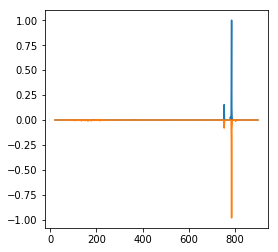

In [45]:
plot_spectra(23)

[103 104 105 107 115 116 117 120 121 123 127 128 131 132 135 147 148 163
 176 191]


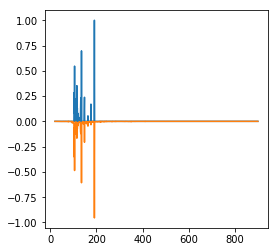

In [46]:
plot_spectra(24)

[ 63  68  91  95 103 104 105 107 109 110 117 121 131 132 135 136 139 141
 145 147 149 151 159 160 161 163 165 168 169 173 175 176 177 178 179 180
 184 185 187 188 189 190 191 192 193 195 196 197 198 199 201 202 203 205
 206 207 208 209 210 211 213 215 216 217 219 220 221 222 223 224 225 226
 229 231 233 239 240 241 242 243 244 245 247 252 253 254 256 257 258 259
 260 261 262 267 270 271 275 276 277 279 285 286 287 303 304 305 306 321
 322 323 324 335 336 337]


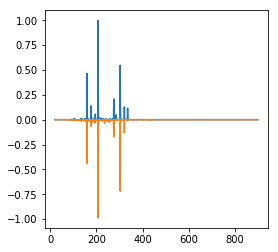

In [47]:
plot_spectra(1561)